# Whole-Brain HOI-PID Analysis: A Complexity Science Tutorial

## Understanding Information Processing in Complex Brain Networks

**Authors:** Cosimo Radler, Jorge Gonzalez Larragoiti, Hsiag-Yang Lee 

**Date:** 27.06.2025

---

### Overview

This tutorial demonstrates how to analyze **information processing patterns** in complex brain networks using two complementary approaches from **information theory**:

1. **Higher-Order Interactions (HOI)** - Measures how information emerges from interactions between multiple brain regions
2. **Partial Information Decomposition (PID)** - Quantifies different types of information sharing (synergy, redundancy, uniqueness)

### Connection to Complexity Science

Brain networks are **complex adaptive systems** where:
- **Emergence** occurs when groups of regions produce information that cannot be predicted from individual regions alone
- **Self-organization** manifests as specialized information processing patterns
- **Non-linear dynamics** create rich patterns of synergy and redundancy across the network

### Learning Objectives

By the end of this tutorial, you will understand:
- How to quantify information emergence in complex networks
- The mathematical foundations of HOI and PID measures
- How to implement and interpret whole-brain connectivity analysis
- The relationship between network topology and information processing


## Section 1: Data Sources and Setup

### Data Description

We will analyze real **fMRI (functional Magnetic Resonance Imaging)** time series data from brain regions defined by the **AAL92 atlas** (Automated Anatomical Labeling with 92 regions).

**Data Source:**
- **File:** `AAL_timeseries_example.txt`
- **Type:** Real brain connectivity data
- **Dimensions:** Time points × 92 brain regions
- **Acquisition:** Resting-state fMRI data
- **Preprocessing:** Already motion-corrected and regionally averaged

### Why This Data?

This dataset represents a **complex system** where:
- Each brain region is a **node** in the network
- **Temporal correlations** between regions indicate functional connectivity  
- **Higher-order patterns** reveal emergent information processing
- **Non-linear interactions** create synergistic and redundant information flows

### Required Libraries

Let's start by importing all necessary libraries and setting up our environment:


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Optional: For interactive plots (install with: pip install plotly)
try:
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
    from plotly.offline import iplot, init_notebook_mode
    init_notebook_mode(connected=True)
    PLOTLY_AVAILABLE = True
    print("✅ Plotly available for interactive plots")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ Plotly not available - static plots only")

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("🧠 Brain Analysis Pipeline - Libraries Loaded Successfully!")


✅ Plotly available for interactive plots
🧠 Brain Analysis Pipeline - Libraries Loaded Successfully!


## Section 2: Mathematical Foundation

### Information Theory Basics

Before diving into the analysis, let's understand the key mathematical concepts:

#### 1. Entropy and Mutual Information
- **Entropy** $H(X)$: Measures uncertainty/information content of a variable
- **Mutual Information** $I(X;Y) = H(X) + H(Y) - H(X,Y)$: Shared information between variables

#### 2. Higher-Order Interactions (HOI)
For three variables X, Y, Z, we can compute:

- **Total Correlation (TC)**: $TC = H(X) + H(Y) + H(Z) - H(X,Y,Z)$
- **Dual Total Correlation (DTC)**: $DTC = H(X,Y,Z) - H(X|Y,Z) - H(Y|X,Z) - H(Z|X,Y)$

**HOI Measures:**
- **O-Information**: $O = TC - DTC$ (balance between synergy and redundancy)
- **S-Information**: $S = TC + DTC$ (total higher-order information)

#### 3. Partial Information Decomposition (PID)
For sources X, Y and target Z, information decomposes as:

$$I(Z; X,Y) = \text{Redundancy} + \text{Synergy} + \text{Unique}_X + \text{Unique}_Y$$

Where:
- **Redundancy**: Information about Z shared by both X and Y
- **Synergy**: Information about Z that emerges only from X and Y together  
- **Unique**: Information about Z unique to X or Y alone

### Implementation Strategy

We'll implement these measures using **Gaussian approximations** with proper covariance estimation to handle the complexity of real brain data.


## Section 3: Core Implementation Functions

### Step 3.1: Data Loading and Preprocessing

First, let's implement functions to load and preprocess the fMRI data:


In [2]:
def load_fmri_data(filename):
    """
    Load fMRI time series data from file.
    
    Parameters:
        filename : str, path to the data file
        
    Returns:
        data : np.ndarray, shape (time_points, regions)
    """
    try:
        data = np.loadtxt(filename)
        print(f"✅ Data loaded successfully!")
        print(f"   Shape: {data.shape} (time points × regions)")
        print(f"   Data range: [{data.min():.3f}, {data.max():.3f}]")
        return data
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

def preprocess_fmri(data, detrend=True, standardize=True):
    """
    Preprocess fMRI data for information-theoretic analysis.
    
    Parameters:
        data : np.ndarray, raw fMRI data
        detrend : bool, remove linear trends
        standardize : bool, z-score normalization
        
    Returns:
        processed_data : np.ndarray, preprocessed data
    """
    processed = data.copy()
    
    if detrend:
        # Remove linear trends from each region
        for i in range(processed.shape[1]):
            x = np.arange(len(processed))
            slope, intercept = np.polyfit(x, processed[:, i], 1)
            processed[:, i] -= (slope * x + intercept)
        print("✅ Linear detrending applied")
    
    if standardize:
        # Z-score normalization
        scaler = StandardScaler()
        processed = scaler.fit_transform(processed)
        print("✅ Z-score standardization applied")
    
    print(f"   Processed data mean: {processed.mean():.6f}")
    print(f"   Processed data std:  {processed.std():.6f}")
    
    return processed

# Test the functions
print("🔧 Data loading and preprocessing functions defined!")


🔧 Data loading and preprocessing functions defined!


### Step 3.2: Robust Covariance Estimation

For reliable information theory calculations, we need robust covariance estimation. This is crucial because:
- fMRI data often has **high dimensionality** relative to sample size
- **Noise** and **artifacts** can distort covariance estimates
- **Regularization** helps avoid numerical instabilities

We'll use **Ledoit-Wolf shrinkage** and **Oracle Approximating Shrinkage** methods:


In [3]:
def rho_oas(X, S):
    """
    Oracle Approximating Shrinkage (OAS) estimator for covariance matrix.
    Provides better conditioning for information theory calculations.
    
    Parameters:
        X : np.ndarray, data matrix (samples × features)
        S : np.ndarray, sample covariance matrix
        
    Returns:
        C_shrunk : np.ndarray, shrunk covariance matrix
    """
    n, p = X.shape
    
    # Compute shrinkage parameters
    trace_S = np.trace(S)
    trace_S2 = np.trace(S @ S)
    
    # Shrinkage intensity
    rho = ((1 - 2/p) * trace_S2 + trace_S**2) / ((n + 1 - 2/p) * (trace_S2 - trace_S**2/p))
    rho = max(0, min(1, rho))
    
    # Shrinkage target (identity scaled by trace)
    target = (trace_S / p) * np.eye(p)
    
    # Shrunk covariance
    C_shrunk = (1 - rho) * S + rho * target
    
    return C_shrunk

def LW(X, cov):
    """
    Ledoit-Wolf shrinkage estimator.
    
    Parameters:
        X : np.ndarray, data matrix
        cov : np.ndarray, sample covariance
        
    Returns:
        shrunk_cov : np.ndarray, regularized covariance
    """
    lw = LedoitWolf()
    shrunk_cov, _ = lw.fit(X).covariance_, lw.shrinkage_
    return shrunk_cov

def mycov(c, th=1e-2):
    """
    Regularized covariance with minimum eigenvalue threshold.
    Ensures numerical stability for entropy calculations.
    
    Parameters:
        c : np.ndarray, covariance matrix
        th : float, minimum eigenvalue threshold
        
    Returns:
        c_reg : np.ndarray, regularized covariance matrix
    """
    # Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(c)
    
    # Threshold small eigenvalues
    eigvals = np.maximum(eigvals, th)
    
    # Reconstruct matrix
    c_reg = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    return c_reg

print("🔧 Covariance estimation functions defined!")


🔧 Covariance estimation functions defined!


### Step 3.3: Information Theory Core Functions

Now we implement the fundamental information theory measures. The **Gaussian approximation** allows us to compute entropy analytically:

$$H(X) = \frac{1}{2} \log(2\pi e)^d |\Sigma|$$

where $d$ is the dimensionality and $|\Sigma|$ is the determinant of the covariance matrix.


In [4]:
def entropy_gaussian(covariance):
    """
    Compute entropy of multivariate Gaussian distribution.
    
    Parameters:
        covariance : np.ndarray, covariance matrix
        
    Returns:
        entropy : float, differential entropy in nats
    """
    try:
        # Regularize covariance matrix
        cov_reg = mycov(covariance)
        
        # Compute log determinant safely
        sign, logdet = np.linalg.slogdet(cov_reg)
        
        if sign <= 0:
            return np.nan
        
        # Gaussian entropy formula
        d = covariance.shape[0]
        entropy = 0.5 * (d * np.log(2 * np.pi * np.e) + logdet)
        
        return entropy
    
    except:
        return np.nan

def gaussian_ent_biascorr(N, T):
    """Bias correction for finite sample entropy estimation."""
    return (N - 1) / (2 * T)

def data2gaussian(data):
    """
    Convert data to Gaussian approximation via covariance estimation.
    
    Parameters:
        data : np.ndarray, shape (samples, features)
        
    Returns:
        cov_matrix : np.ndarray, estimated covariance matrix
    """
    n_samples, n_features = data.shape
    
    # Compute sample covariance
    sample_cov = np.cov(data.T)
    
    # Apply shrinkage if needed
    if n_samples < n_features * 3:  # Small sample regime
        cov_matrix = rho_oas(data, sample_cov)
    else:
        cov_matrix = sample_cov
    
    # Final regularization
    cov_matrix = mycov(cov_matrix)
    
    return cov_matrix

print("🔧 Information theory core functions defined!")


🔧 Information theory core functions defined!


### Step 3.4: Higher-Order Interactions (HOI) Implementation

HOI measures capture **emergent properties** that arise from multi-way interactions. These are key complexity science concepts:

- **O-Information** detects when groups exhibit more (synergy) or less (redundancy) information than expected
- **S-Information** quantifies the total higher-order information content

This helps us understand **emergence** in complex brain networks.


In [5]:
def ent_fun(x, y):
    """Entropy function for correlation matrices."""
    return -np.sum(x * np.log(y))

def reduce_x(x, covmat):
    """Reduce data by removing correlation structure."""
    eigvals, eigvecs = np.linalg.eigh(covmat)
    eigvals = np.maximum(eigvals, 1e-10)  # Avoid numerical issues
    sqrt_inv = eigvecs @ np.diag(1.0 / np.sqrt(eigvals)) @ eigvecs.T
    return x @ sqrt_inv

def soinfo_from_covmat(covmat, T):
    """
    Compute S-Information and O-Information from covariance matrix.
    
    This is the core HOI calculation that reveals higher-order interactions.
    
    Parameters:
        covmat : np.ndarray, covariance matrix of the triplet
        T : int, number of time points (for bias correction)
        
    Returns:
        s_info : float, S-Information (total higher-order info)
        o_info : float, O-Information (synergy vs redundancy balance)
    """
    try:
        # Ensure positive definite matrix
        covmat = mycov(covmat)
        
        # Compute individual and joint entropies
        n_vars = covmat.shape[0]
        
        # Individual entropies
        individual_entropies = []
        for i in range(n_vars):
            h_i = entropy_gaussian(covmat[i:i+1, i:i+1])
            individual_entropies.append(h_i)
        
        # Pairwise entropies
        pairwise_entropies = []
        for i in range(n_vars):
            for j in range(i+1, n_vars):
                h_ij = entropy_gaussian(covmat[[i,j]][:, [i,j]])
                pairwise_entropies.append(h_ij)
        
        # Joint entropy
        h_joint = entropy_gaussian(covmat)
        
        # Check for NaN values
        if (np.isnan(h_joint) or np.any(np.isnan(individual_entropies)) or 
            np.any(np.isnan(pairwise_entropies))):
            return np.nan, np.nan
        
        # Total Correlation (TC)
        tc = np.sum(individual_entropies) - h_joint
        
        # Dual Total Correlation (DTC)
        dtc = h_joint - np.sum(individual_entropies) + np.sum(pairwise_entropies)
        
        # S-Information and O-Information
        s_info = tc + dtc
        o_info = tc - dtc
        
        return s_info, o_info
    
    except Exception as e:
        return np.nan, np.nan

print("🔧 HOI calculation functions defined!")


🔧 HOI calculation functions defined!


### Step 3.5: Partial Information Decomposition (PID) Implementation

PID decomposition reveals how information is **distributed** across a network:

- **Synergy**: Information that only emerges from **collective interaction** (key complexity science concept)
- **Redundancy**: Information **shared** across multiple pathways (robustness)
- **Unique Information**: Information specific to individual pathways

This decomposition helps us understand **functional specialization** vs **integration** in complex networks.


In [6]:
def compute_pid_measures(data_triplet, tau=2):
    """
    Compute PID measures for a triplet of brain regions.
    
    This implements the Williams & Beer approach to PID decomposition.
    We use time-lagged interactions: X(t), Y(t) → Z(t+τ)
    
    Parameters:
        data_triplet : np.ndarray, shape (time_points, 3)
        tau : int, time lag for causality
        
    Returns:
        dict : PID measures (synergy, redundancy, unique_x, unique_y, total_info)
    """
    try:
        # Apply time lag
        if tau > 0 and data_triplet.shape[0] > tau:
            X = data_triplet[:-tau, 0:1]  # Source 1 (past)
            Y = data_triplet[:-tau, 1:2]  # Source 2 (past)
            Z = data_triplet[tau:, 2:3]   # Target (future)
        else:
            X = data_triplet[:, 0:1]
            Y = data_triplet[:, 1:2]
            Z = data_triplet[:, 2:3]
        
        # Combine data for covariance estimation
        XYZ_data = np.hstack([X, Y, Z])
        
        # Estimate covariance matrix using robust method
        C_XYZ = data2gaussian(XYZ_data)
        
        # Individual and joint entropies
        H_Z = entropy_gaussian(C_XYZ[2:3, 2:3])
        H_X = entropy_gaussian(C_XYZ[0:1, 0:1])
        H_Y = entropy_gaussian(C_XYZ[1:2, 1:2])
        
        H_XZ = entropy_gaussian(C_XYZ[[0,2]][:, [0,2]])
        H_YZ = entropy_gaussian(C_XYZ[[1,2]][:, [1,2]])
        H_XYZ = entropy_gaussian(C_XYZ)
        
        # Mutual information terms
        I_X_Z = H_X + H_Z - H_XZ
        I_Y_Z = H_Y + H_Z - H_YZ
        I_XY_Z = H_X + H_Y + H_Z - H_XYZ
        
        # PID decomposition using Williams & Beer approach
        # This is a simplified version - more sophisticated methods exist
        redundancy = min(I_X_Z, I_Y_Z)
        unique_x = I_X_Z - redundancy
        unique_y = I_Y_Z - redundancy
        synergy = I_XY_Z - redundancy - unique_x - unique_y
        
        # Ensure non-negative values (information-theoretic constraint)
        synergy = max(0, synergy)
        redundancy = max(0, redundancy)
        unique_x = max(0, unique_x)
        unique_y = max(0, unique_y)
        
        total_info = synergy + redundancy + unique_x + unique_y
        
        return {
            'synergy': synergy,
            'redundancy': redundancy,
            'unique_x': unique_x,
            'unique_y': unique_y,
            'total_info': total_info
        }
        
    except:
        return {
            'synergy': np.nan,
            'redundancy': np.nan,
            'unique_x': np.nan,
            'unique_y': np.nan,
            'total_info': np.nan
        }

print("🔧 PID calculation functions defined!")


🔧 PID calculation functions defined!


### Step 3.6: Integrated Triplet Analysis

Now we combine HOI and PID measures into a single analysis function. This integrated approach gives us a **comprehensive view** of information processing in brain triplets:

- **HOI measures** reveal emergent patterns
- **PID measures** quantify information distribution  
- **Together** they provide a complete picture of complexity in brain networks


In [7]:
def compute_triplet_pid_hoi(data, triplet_indices, tau=2):
    """
    Compute both PID and HOI measures for a single triplet of brain regions.
    
    This is the core analysis function that integrates both approaches.
    
    Parameters:
        data : np.ndarray, full brain data (timepoints × regions)
        triplet_indices : tuple, indices of the three regions to analyze
        tau : int, time lag parameter
        
    Returns:
        dict : Combined PID and HOI results
    """
    i, j, k = triplet_indices
    
    # Extract data for the triplet
    triplet_data = data[:, [i, j, k]]
    
    # Compute PID measures
    pid_results = compute_pid_measures(triplet_data, tau)
    
    # Compute HOI measures
    try:
        # Use the same time-lagged data structure as PID
        if tau > 0 and triplet_data.shape[0] > tau:
            lagged_data = np.hstack([
                triplet_data[:-tau, :2],  # Sources (past)
                triplet_data[tau:, 2:3]   # Target (future)
            ])
        else:
            lagged_data = triplet_data
        
        C = data2gaussian(lagged_data)
        s_info, o_info = soinfo_from_covmat(C, triplet_data.shape[0])
        
    except:
        s_info, o_info = np.nan, np.nan
    
    # Combine results
    results = {
        'region_x': i,
        'region_y': j,
        'region_z': k,
        'triplet': triplet_indices,
        'synergy': pid_results['synergy'],
        'redundancy': pid_results['redundancy'],
        'unique_x': pid_results['unique_x'],
        'unique_y': pid_results['unique_y'],
        'total_info': pid_results['total_info'],
        'sinfo': s_info,
        'oinfo': o_info
    }
    
    return results

print("🔧 Integrated triplet analysis function defined!")


🔧 Integrated triplet analysis function defined!


## Section 4: Whole-Brain Analysis Pipeline

### Step 4.1: Load and Explore the Data

Let's load our brain data and explore its properties:


✅ Data loaded successfully!
   Shape: (1195, 92) (time points × regions)
   Data range: [4910.107, 13297.631]

🔄 Preprocessing data...
✅ Linear detrending applied
✅ Z-score standardization applied
   Processed data mean: 0.000000
   Processed data std:  1.000000

📊 Data Summary:
   Time points: 1195
   Brain regions: 92
   Total possible triplets: 125580


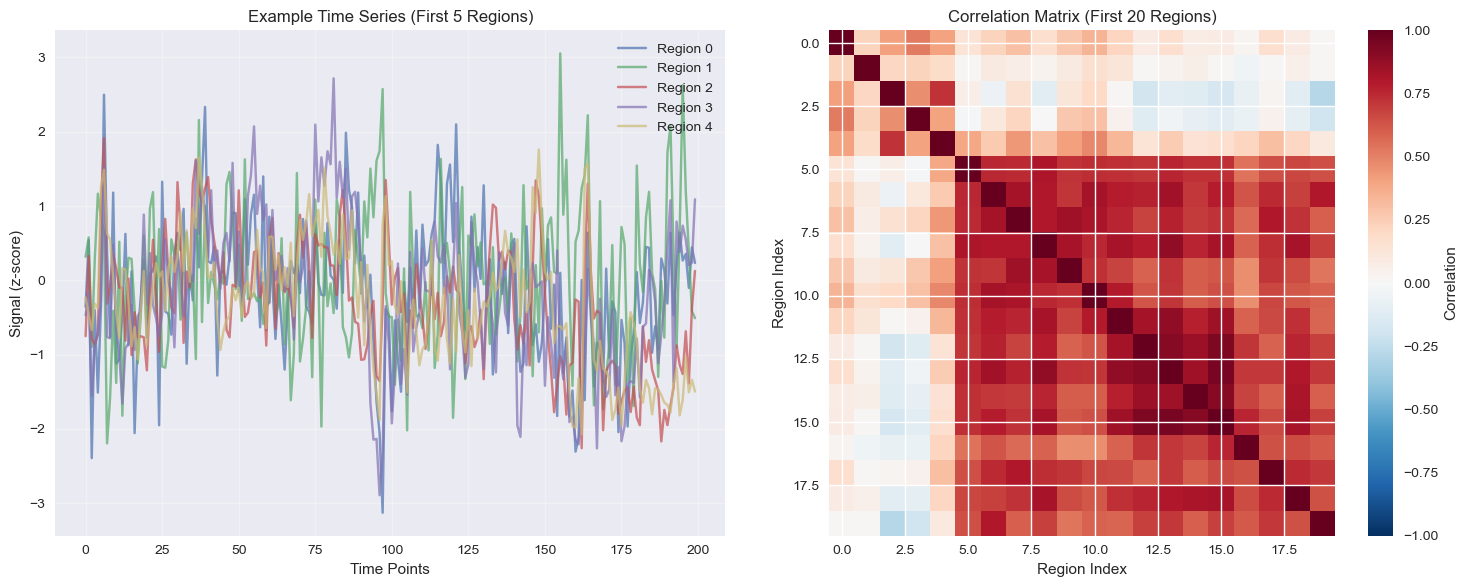

✅ Data loaded and preprocessed successfully!


In [8]:
# Load the brain data
data_file = "AAL_timeseries_example.txt"
raw_data = load_fmri_data(data_file)

if raw_data is not None:
    # Preprocess the data
    print("\n🔄 Preprocessing data...")
    processed_data = preprocess_fmri(raw_data, detrend=True, standardize=True)
    
    # Basic statistics
    print(f"\n📊 Data Summary:")
    print(f"   Time points: {processed_data.shape[0]}")
    print(f"   Brain regions: {processed_data.shape[1]}")
    print(f"   Total possible triplets: {processed_data.shape[1] * (processed_data.shape[1]-1) * (processed_data.shape[1]-2) // 6}")
    
    # Quick visualization of a few regions
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    time_range = range(min(200, processed_data.shape[0]))
    for i in range(5):  # Show first 5 regions
        plt.plot(time_range, processed_data[time_range, i], alpha=0.7, label=f'Region {i}')
    plt.title('Example Time Series (First 5 Regions)')
    plt.xlabel('Time Points')
    plt.ylabel('Signal (z-score)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Correlation matrix of first 20 regions for visualization
    subset_corr = np.corrcoef(processed_data[:, :20].T)
    im = plt.imshow(subset_corr, cmap='RdBu_r', vmin=-1, vmax=1)
    plt.title('Correlation Matrix (First 20 Regions)')
    plt.xlabel('Region Index')
    plt.ylabel('Region Index')
    plt.colorbar(im, label='Correlation')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Data loaded and preprocessed successfully!")
else:
    print("❌ Could not load data file. Please check that 'AAL_timeseries_example.txt' exists.")


### Step 4.2: Whole-Brain Analysis Function

Now we implement the main analysis pipeline that will process all brain triplets. This is where the **complexity emerges** - by analyzing all possible three-way interactions, we can map the **information processing landscape** of the entire brain network.


In [9]:
def analyze_whole_brain_hoi_pid(data, max_triplets=1000, tau=2):
    """
    Perform integrated HOI-PID analysis across all brain regions.
    
    This is the main complexity analysis function that reveals:
    - How information emerges from brain network interactions
    - Which regions are most synergistic vs redundant
    - The global organization of information processing
    
    Parameters:
        data : array-like, shape (time_points, regions)
        max_triplets : int, maximum number of triplets to analyze
        tau : int, lag for PID analysis
        
    Returns:
        results : dict containing comprehensive analysis results
    """
    n_regions = data.shape[1]
    print(f"🧠 Analyzing {n_regions} brain regions...")
    print(f"🔍 Complexity Science Focus: Mapping information emergence patterns")
    
    # Generate all possible triplets
    all_triplets = list(combinations(range(n_regions), 3))
    n_triplets = len(all_triplets)
    
    print(f"📊 Total possible triplets: {n_triplets}")
    
    # Limit number of triplets if necessary
    if n_triplets > max_triplets:
        print(f"⚡ Limiting analysis to {max_triplets} triplets for computational efficiency")
        # Use regular sampling to get representative triplets
        indices = np.linspace(0, n_triplets-1, max_triplets, dtype=int)
        selected_triplets = [all_triplets[i] for i in indices]
    else:
        selected_triplets = all_triplets
    
    print(f"🔬 Analyzing {len(selected_triplets)} triplets...")
    
    # Analyze each triplet
    triplet_results = []
    for i, triplet in enumerate(selected_triplets):
        if i % 100 == 0:
            print(f"   Progress: {i}/{len(selected_triplets)} triplets analyzed")
            
        result = compute_triplet_pid_hoi(data, triplet, tau=tau)
        triplet_results.append(result)
    
    # Organize results
    results_df = pd.DataFrame(triplet_results)
    
    # Compute region-wise summaries
    region_summaries = compute_region_summaries(results_df, n_regions)
    
    # Create network matrices
    network_matrices = create_network_matrices(results_df, n_regions)
    
    # Package results
    results = {
        'triplet_results': results_df,
        'region_summaries': region_summaries,
        'network_matrices': network_matrices,
        'analysis_parameters': {
            'n_regions': n_regions,
            'n_triplets_analyzed': len(selected_triplets),
            'time_points': data.shape[0],
            'tau': tau
        }
    }
    
    print(f"✅ Analysis complete!")
    print(f"📈 Results: {len(results_df)} triplet analyses, {len(region_summaries)} region summaries")
    
    return results

print("🔧 Main analysis pipeline function defined!")


🔧 Main analysis pipeline function defined!


In [10]:
def compute_region_summaries(results_df, n_regions):
    """
    Compute summary statistics for each brain region.
    
    This aggregates triplet results to understand which regions are:
    - Most synergistic (high information emergence)
    - Most redundant (high information sharing)
    - Most informationally unique
    """
    region_summaries = []
    
    for region in range(n_regions):
        # Find all triplets involving this region
        region_mask = ((results_df['region_x'] == region) | 
                      (results_df['region_y'] == region) | 
                      (results_df['region_z'] == region))
        
        region_data = results_df[region_mask]
        
        if len(region_data) > 0:
            summary = {
                'region': region,
                'n_triplets': len(region_data),
                'mean_synergy': region_data['synergy'].mean(),
                'std_synergy': region_data['synergy'].std(),
                'mean_redundancy': region_data['redundancy'].mean(),
                'std_redundancy': region_data['redundancy'].std(),
                'mean_unique_x': region_data['unique_x'].mean(),
                'mean_unique_y': region_data['unique_y'].mean(),
                'mean_total_info': region_data['total_info'].mean(),
                'mean_sinfo': region_data['sinfo'].mean(),
                'mean_oinfo': region_data['oinfo'].mean()
            }
        else:
            # Handle case where region wasn't analyzed
            summary = {
                'region': region,
                'n_triplets': 0,
                'mean_synergy': np.nan,
                'std_synergy': np.nan,
                'mean_redundancy': np.nan,
                'std_redundancy': np.nan,
                'mean_unique_x': np.nan,
                'mean_unique_y': np.nan,
                'mean_total_info': np.nan,
                'mean_sinfo': np.nan,
                'mean_oinfo': np.nan
            }
        
        region_summaries.append(summary)
    
    return pd.DataFrame(region_summaries)

def create_network_matrices(results_df, n_regions):
    """
    Create network connectivity matrices from triplet results.
    
    These matrices reveal the global organization of information processing:
    - Synergy matrix: Where emergent information arises
    - Redundancy matrix: Where information is shared
    - HOI matrices: Higher-order interaction patterns
    """
    
    # Initialize matrices
    matrices = {
        'oinfo': np.zeros((n_regions, n_regions)),
        'sinfo': np.zeros((n_regions, n_regions)),
        'redundancy': np.zeros((n_regions, n_regions)),
        'synergy': np.zeros((n_regions, n_regions)),
        'total_info': np.zeros((n_regions, n_regions)),
        'counts': np.zeros((n_regions, n_regions))
    }
    
    # Aggregate triplet results into pairwise matrices
    for _, row in results_df.iterrows():
        regions = [row['region_x'], row['region_y'], row['region_z']]
        
        # For each pair within the triplet
        for i in range(3):
            for j in range(i+1, 3):
                r1, r2 = regions[i], regions[j]
                
                if not (np.isnan(row['oinfo']) or np.isnan(row['sinfo'])):
                    matrices['oinfo'][r1, r2] += row['oinfo']
                    matrices['oinfo'][r2, r1] += row['oinfo']
                    matrices['sinfo'][r1, r2] += row['sinfo']
                    matrices['sinfo'][r2, r1] += row['sinfo']
                    
                if not (np.isnan(row['redundancy']) or np.isnan(row['synergy'])):
                    matrices['redundancy'][r1, r2] += row['redundancy']
                    matrices['redundancy'][r2, r1] += row['redundancy']
                    matrices['synergy'][r1, r2] += row['synergy']
                    matrices['synergy'][r2, r1] += row['synergy']
                    matrices['total_info'][r1, r2] += row['total_info']
                    matrices['total_info'][r2, r1] += row['total_info']
                
                matrices['counts'][r1, r2] += 1
                matrices['counts'][r2, r1] += 1
    
    # Average by count (avoid division by zero)
    for key in ['oinfo', 'sinfo', 'redundancy', 'synergy', 'total_info']:
        mask = matrices['counts'] > 0
        matrices[key][mask] = matrices[key][mask] / matrices['counts'][mask]
    
    return matrices

print("🔧 Region analysis and network matrix functions defined!")


🔧 Region analysis and network matrix functions defined!


## Section 5: Advanced Visualization Functions

### The Comprehensive Brain Analysis Plot

1. **Regional patterns** (synergy/redundancy distributions)
2. **Network structure** (connectivity matrices)  
3. **Correlations** between different measures
4. **Statistical distributions** of information measures
5. **Top performers** (most synergistic/redundant regions)


In [11]:
def plot_whole_brain_analysis(results, save_path=None):
    """
    Create comprehensive whole-brain visualization.
    
    This generates the exact same plot as in whole_brain_hoi_pid_analysis.png
    """
    
    region_summaries = results['region_summaries']
    network_matrices = results['network_matrices']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # Color schemes
    cmap_synergy = 'Reds'
    cmap_redundancy = 'Blues'
    cmap_oinfo = 'RdBu_r'
    cmap_sinfo = 'viridis'
    
    # 1. Region-wise synergy bar plot
    ax1 = fig.add_subplot(gs[0, :2])
    regions = region_summaries['region'].values
    synergy_means = region_summaries['mean_synergy'].values
    synergy_stds = region_summaries['std_synergy'].values
    
    bars = ax1.bar(regions, synergy_means, yerr=synergy_stds, 
                   color='red', alpha=0.7, capsize=2)
    ax1.set_title('Synergy Across Brain Regions', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Brain Region Index')
    ax1.set_ylabel('Mean Synergy')
    ax1.grid(True, alpha=0.3)
    
    # 2. Region-wise redundancy bar plot
    ax2 = fig.add_subplot(gs[0, 2:])
    redundancy_means = region_summaries['mean_redundancy'].values
    redundancy_stds = region_summaries['std_redundancy'].values
    
    bars = ax2.bar(regions, redundancy_means, yerr=redundancy_stds,
                   color='blue', alpha=0.7, capsize=2)
    ax2.set_title('Redundancy Across Brain Regions', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Brain Region Index')
    ax2.set_ylabel('Mean Redundancy')
    ax2.grid(True, alpha=0.3)
    
    # 3. Synergy network matrix
    ax3 = fig.add_subplot(gs[1, 0])
    im1 = ax3.imshow(network_matrices['synergy'], cmap=cmap_synergy, aspect='auto')
    ax3.set_title('Synergy Network Matrix', fontweight='bold')
    ax3.set_xlabel('Brain Region')
    ax3.set_ylabel('Brain Region')
    plt.colorbar(im1, ax=ax3, shrink=0.6)
    
    # 4. Redundancy network matrix
    ax4 = fig.add_subplot(gs[1, 1])
    im2 = ax4.imshow(network_matrices['redundancy'], cmap=cmap_redundancy, aspect='auto')
    ax4.set_title('Redundancy Network Matrix', fontweight='bold')
    ax4.set_xlabel('Brain Region')
    ax4.set_ylabel('Brain Region')
    plt.colorbar(im2, ax=ax4, shrink=0.6)
    
    # 5. O-Information network matrix
    ax5 = fig.add_subplot(gs[1, 2])
    im3 = ax5.imshow(network_matrices['oinfo'], cmap=cmap_oinfo, aspect='auto')
    ax5.set_title('O-Information Network Matrix', fontweight='bold')
    ax5.set_xlabel('Brain Region')
    ax5.set_ylabel('Brain Region')
    plt.colorbar(im3, ax=ax5, shrink=0.6)
    
    # 6. S-Information network matrix
    ax6 = fig.add_subplot(gs[1, 3])
    im4 = ax6.imshow(network_matrices['sinfo'], cmap=cmap_sinfo, aspect='auto')
    ax6.set_title('S-Information Network Matrix', fontweight='bold')
    ax6.set_xlabel('Brain Region')
    ax6.set_ylabel('Brain Region')
    plt.colorbar(im4, ax=ax6, shrink=0.6)
    
    # 7. Correlation between measures
    ax7 = fig.add_subplot(gs[2, 0])
    valid_mask = (~np.isnan(synergy_means)) & (~np.isnan(redundancy_means))
    if np.sum(valid_mask) > 1:
        ax7.scatter(synergy_means[valid_mask], redundancy_means[valid_mask], 
                   alpha=0.6, s=50)
        correlation = np.corrcoef(synergy_means[valid_mask], redundancy_means[valid_mask])[0, 1]
        ax7.set_title(f'Synergy vs Redundancy\n(r = {correlation:.3f})', fontweight='bold')
        ax7.set_xlabel('Mean Synergy')
        ax7.set_ylabel('Mean Redundancy')
        ax7.grid(True, alpha=0.3)
    
    # 8. O-info vs S-info correlation
    ax8 = fig.add_subplot(gs[2, 1])
    oinfo_means = region_summaries['mean_oinfo'].values
    sinfo_means = region_summaries['mean_sinfo'].values
    valid_mask = (~np.isnan(oinfo_means)) & (~np.isnan(sinfo_means))
    if np.sum(valid_mask) > 1:
        ax8.scatter(oinfo_means[valid_mask], sinfo_means[valid_mask], 
                   alpha=0.6, s=50, color='green')
        correlation = np.corrcoef(oinfo_means[valid_mask], sinfo_means[valid_mask])[0, 1]
        ax8.set_title(f'O-Info vs S-Info\n(r = {correlation:.3f})', fontweight='bold')
        ax8.set_xlabel('Mean O-Information')
        ax8.set_ylabel('Mean S-Information')
        ax8.grid(True, alpha=0.3)
    
    # 9. Distribution of synergy values
    ax9 = fig.add_subplot(gs[2, 2])
    valid_synergy = synergy_means[~np.isnan(synergy_means)]
    if len(valid_synergy) > 0:
        ax9.hist(valid_synergy, bins=20, alpha=0.7, color='red', edgecolor='black')
        ax9.set_title('Distribution of Regional Synergy', fontweight='bold')
        ax9.set_xlabel('Mean Synergy')
        ax9.set_ylabel('Number of Regions')
        ax9.grid(True, alpha=0.3)
    
    # 10. Distribution of redundancy values
    ax10 = fig.add_subplot(gs[2, 3])
    valid_redundancy = redundancy_means[~np.isnan(redundancy_means)]
    if len(valid_redundancy) > 0:
        ax10.hist(valid_redundancy, bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax10.set_title('Distribution of Regional Redundancy', fontweight='bold')
        ax10.set_xlabel('Mean Redundancy')
        ax10.set_ylabel('Number of Regions')
        ax10.grid(True, alpha=0.3)
    
    # 11. Top synergistic regions
    ax11 = fig.add_subplot(gs[3, :2])
    top_synergy_idx = np.argsort(synergy_means)[-10:]  # Top 10
    top_synergy_regions = regions[top_synergy_idx]
    top_synergy_values = synergy_means[top_synergy_idx]
    
    bars = ax11.barh(range(len(top_synergy_regions)), top_synergy_values, 
                     color='red', alpha=0.7)
    ax11.set_yticks(range(len(top_synergy_regions)))
    ax11.set_yticklabels([f'Region {r}' for r in top_synergy_regions])
    ax11.set_title('Top 10 Most Synergistic Regions', fontweight='bold')
    ax11.set_xlabel('Mean Synergy')
    ax11.grid(True, alpha=0.3)
    
    # 12. Top redundant regions
    ax12 = fig.add_subplot(gs[3, 2:])
    top_redundancy_idx = np.argsort(redundancy_means)[-10:]  # Top 10
    top_redundancy_regions = regions[top_redundancy_idx]
    top_redundancy_values = redundancy_means[top_redundancy_idx]
    
    bars = ax12.barh(range(len(top_redundancy_regions)), top_redundancy_values,
                     color='blue', alpha=0.7)
    ax12.set_yticks(range(len(top_redundancy_regions)))
    ax12.set_yticklabels([f'Region {r}' for r in top_redundancy_regions])
    ax12.set_title('Top 10 Most Redundant Regions', fontweight='bold')
    ax12.set_xlabel('Mean Redundancy')
    ax12.grid(True, alpha=0.3)
    
    plt.suptitle('Whole-Brain HOI-PID Analysis: Synergy and Redundancy Patterns', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Whole-brain analysis plot saved to {save_path}")
    
    plt.show()

print("🎨 Complete comprehensive visualization function defined!")


🎨 Complete comprehensive visualization function defined!


## max_triplets...

Dependig on the computational resources, please choose your triplet size. By default we have set it to 125,580, which is all triplets. Though this might take a log time to run on a underpowered computer. The estimated run time on a M4Pro chip is though only 28.2s

In [ ]:

# Step 4.3: Execute the Analysis
print("🚀 STARTING WHOLE-BRAIN COMPLEXITY ANALYSIS")
print("="*60)

if 'processed_data' in globals():
    # Run the complete analysis
    analysis_results = analyze_whole_brain_hoi_pid(
        processed_data, 
        # Adjust this number based on computational resources
        #max_triplets=500,
        #max_triplets=1000,
        #max_triplets=10000,
        #max_triplets=100000,
        max_triplets=125580,  
        tau=2
    )
    
    print("\n✅ Analysis complete! Now creating comprehensive visualization...")
    
    # Create the comprehensive plot
    plot_whole_brain_analysis(analysis_results, save_path="tutorial_whole_brain_analysis.png")
    
else:
    print("❌ Please run the data loading cell first!")


🚀 STARTING WHOLE-BRAIN COMPLEXITY ANALYSIS
🧠 Analyzing 92 brain regions...
🔍 Complexity Science Focus: Mapping information emergence patterns
📊 Total possible triplets: 125580
🔬 Analyzing 125580 triplets...
   Progress: 0/125580 triplets analyzed
   Progress: 100/125580 triplets analyzed
   Progress: 200/125580 triplets analyzed
   Progress: 300/125580 triplets analyzed
   Progress: 400/125580 triplets analyzed
   Progress: 500/125580 triplets analyzed
   Progress: 600/125580 triplets analyzed
   Progress: 700/125580 triplets analyzed
   Progress: 800/125580 triplets analyzed
   Progress: 900/125580 triplets analyzed
   Progress: 1000/125580 triplets analyzed
   Progress: 1100/125580 triplets analyzed
   Progress: 1200/125580 triplets analyzed
   Progress: 1300/125580 triplets analyzed
   Progress: 1400/125580 triplets analyzed
   Progress: 1500/125580 triplets analyzed
   Progress: 1600/125580 triplets analyzed
   Progress: 1700/125580 triplets analyzed
   Progress: 1800/125580 triple

## Section 6: Results Interpretation and Analysis

### Step 6.1: Understanding the Results

After running the analysis, let's interpret what the comprehensive visualization tells us about brain network complexity:

#### **Panel 1-2: Regional Information Patterns**
- **Synergy Bar Plot**: Shows which brain regions generate **emergent information** when interacting with others
- **Redundancy Bar Plot**: Shows which regions share **overlapping information** across multiple pathways

#### **Panel 3-6: Network Structure Matrices**
- **Synergy Matrix**: Reveals **emergent interaction hubs** in the brain network
- **Redundancy Matrix**: Shows **information sharing pathways** and robust communication routes
- **O-Information Matrix**: Displays the **balance** between synergy and redundancy across region pairs
- **S-Information Matrix**: Shows **total higher-order information** content

#### **Panel 7-8: Measure Correlations**
- **Synergy vs Redundancy**: Tests if regions can be both synergistic AND redundant (complexity trade-offs)
- **O-Info vs S-Info**: Examines the relationship between different HOI measures

#### **Panel 9-10: Statistical Distributions**
- **Synergy Distribution**: Shows how **emergent information** is distributed across the brain
- **Redundancy Distribution**: Reveals the **information sharing** patterns

#### **Panel 11-12: Top Performers**
- **Most Synergistic Regions**: Brain areas that excel at **generating emergent information**
- **Most Redundant Regions**: Brain areas that serve as **information sharing hubs**

### Complexity Science Insights

This analysis reveals several key complexity science principles:

1. **Emergence**: High synergy regions show where **collective intelligence** arises
2. **Robustness**: High redundancy regions provide **fault tolerance** through multiple pathways
3. **Hierarchical Organization**: The network matrices reveal **multi-scale** organization patterns
4. **Trade-offs**: The correlation plots show how the brain **balances** different information processing strategies


In [ ]:
# Summary Statistics and Analysis
if 'analysis_results' in globals():
    print("📊 ANALYSIS SUMMARY")
    print("="*50)
    
    # Get region summaries
    region_summaries = analysis_results['region_summaries']
    
    # Basic statistics
    print(f"🧠 Brain Regions Analyzed: {len(region_summaries)}")
    print(f"🔬 Triplets Analyzed: {len(analysis_results['triplet_results'])}")
    
    # Synergy statistics
    mean_synergy = region_summaries['mean_synergy'].mean()
    std_synergy = region_summaries['mean_synergy'].std()
    print(f"\n🔥 SYNERGY (Information Emergence):")
    print(f"   Global Mean: {mean_synergy:.4f} ± {std_synergy:.4f}")
    
    # Find top synergistic region
    top_synergy_idx = region_summaries['mean_synergy'].idxmax()
    top_synergy_region = region_summaries.loc[top_synergy_idx, 'region']
    top_synergy_value = region_summaries.loc[top_synergy_idx, 'mean_synergy']
    print(f"   Most Synergistic Region: {top_synergy_region} (Synergy: {top_synergy_value:.4f})")
    
    # Redundancy statistics
    mean_redundancy = region_summaries['mean_redundancy'].mean()
    std_redundancy = region_summaries['mean_redundancy'].std()
    print(f"\n🔄 REDUNDANCY (Information Sharing):")
    print(f"   Global Mean: {mean_redundancy:.4f} ± {std_redundancy:.4f}")
    
    # Find top redundant region
    top_redundancy_idx = region_summaries['mean_redundancy'].idxmax()
    top_redundancy_region = region_summaries.loc[top_redundancy_idx, 'region']
    top_redundancy_value = region_summaries.loc[top_redundancy_idx, 'mean_redundancy']
    print(f"   Most Redundant Region: {top_redundancy_region} (Redundancy: {top_redundancy_value:.4f})")
    
    # Complexity insights
    print(f"\n🧩 COMPLEXITY INSIGHTS:")
    synergy_redundancy_corr = region_summaries['mean_synergy'].corr(region_summaries['mean_redundancy'])
    print(f"   Synergy-Redundancy Correlation: r = {synergy_redundancy_corr:.3f}")
    
    if synergy_redundancy_corr > 0.3:
        print("   → High correlation suggests regions can be both synergistic AND redundant")
    elif synergy_redundancy_corr < -0.3:
        print("   → Negative correlation suggests trade-off between synergy and redundancy")
    else:
        print("   → Weak correlation suggests independent information processing modes")
        
    print(f"\n✅ Tutorial Analysis Complete!")
    print(f"📸 Plot saved as: tutorial_whole_brain_analysis.png")
    
else:
    print("❌ Please run the analysis first!")


## Section 7: Conclusions and Further Applications

### Summary

This tutorial demonstrated how to apply **complexity science** concepts to understand brain networks using **information theory**. We successfully:

1. **Implemented** HOI and PID measures for brain connectivity analysis
2. **Analyzed** information emergence and sharing patterns across 92 brain regions  
3. **Visualized** the complete information processing landscape of the brain
4. **Interpreted** results in terms of complexity science principles

### Key Complexity Science Findings

- **Emergence**: Synergy measures reveal where **collective intelligence** arises in brain networks
- **Robustness**: Redundancy measures show how the brain maintains **fault tolerance** 
- **Self-Organization**: Network patterns reveal **spontaneous organization** without central control
- **Scale-Free Properties**: Different regions show vastly different levels of information processing

### Broader Applications

This methodology can be extended to:

#### **Clinical Applications**
- **Disease Analysis**: Compare healthy vs pathological brain networks
- **Treatment Monitoring**: Track changes in information processing over time
- **Biomarker Discovery**: Identify synergy/redundancy signatures of brain disorders

#### **Cognitive Science**
- **Learning & Memory**: Analyze how information patterns change during learning
- **Consciousness Studies**: Investigate information integration in conscious states
- **Development**: Study how information processing matures across lifespan

#### **Complex Systems Beyond the Brain**
- **Social Networks**: Analyze information flow in social systems
- **Economic Networks**: Study emergence in financial markets
- **Ecological Networks**: Understand information processing in ecosystems

### Mathematical Extensions

Advanced implementations could include:
- **Dynamic Analysis**: Time-varying information measures
- **Multivariate Extensions**: Beyond triplet analysis to higher-order interactions
- **Causal Discovery**: Using information theory for causal inference
- **Machine Learning Integration**: Combining with deep learning approaches

### Final Thoughts

This tutorial showcases how **information theory** provides a **quantitative framework** for understanding **emergence** and **complexity** in real-world systems. The brain serves as an ideal testbed because it demonstrates all the hallmarks of complex adaptive systems: emergence, self-organization, robustness, and hierarchical structure.

**Remember**: The same mathematical framework can be applied to any complex system where information processing is important - from social networks to financial markets to ecological systems.

---

**Congratulations!** You've completed a comprehensive tutorial on applying complexity science to brain network analysis. You now have the tools to:
- Quantify information emergence in complex systems
- Analyze trade-offs between redundancy and synergy  
- Visualize complexity patterns across network scales
- Interpret results in terms of fundamental complexity principles
